# Raven Home Task

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px

from static.constants import *
from src.preprocessor import Preprocessor
from src.utils import customer_cumsum, monthly_revenue_and_transactions,\
    country_amount, top_countries_by_month_year, get_whale_customers, \
        get_whales_by_column
from src.feature_engineering import FeatureEngineering, create_recency_column
from src.model import ClusterModel


In [2]:
# for readability
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 99999)
warnings.filterwarnings("ignore")

In [3]:
# saved the dataframe as parquet from Excel
df = pd.read_parquet('src/df.parquet.gzip')

In [4]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df[invoicedate].min(), df[invoicedate].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [6]:
df[customerid].nunique()

4372

In [7]:
# define the maximum dataset's date as the date for clculating recency
CURRENT_TIME = df[invoicedate].max()

## Preprocessing

before starting with EDA, I performed some cleaning and precprocessing:<br>
-    addition of amount column, defined as quantity*unitprice
-    remove customers that have negative amount spent. in some cases could indicate for fraud
-    remove customers with high return amount, above pre-defined threshold
-    since our goal is to segment customers, i'll drop the transactions without customers. This is questionable since I want to display a full image of the company's state and dropping this transactions may cause bias. However, i decided to drop them


In [8]:
preprocessor = Preprocessor()
processed_df = preprocessor.preprocessing_pipeline(df)
print(f'total customers - {processed_df[customerid].nunique()}')

dropped 42 customers with negative balance
dropped 26 customers with suspicious transaction
total customers - 4304


## EDA

In [9]:
# check the distribution of each customer's amount - binning amount

customer_amount = processed_df.groupby(customerid, as_index=False)[amount].sum()
customer_amount['bin_total_amount'] = pd.qcut(customer_amount[amount], 10)
series_vc = customer_amount['bin_total_amount']
vc = pd.concat([series_vc.value_counts(dropna=False), series_vc
                .value_counts(normalize=True, dropna=False)], keys=['counts', 'normalized_counts'], axis=1)
vc.sort_index()


,counts,normalized_counts
bin_total_amount,,
"(-0.001, 153.906]",431,0.100139
"(153.906, 243.556]",430,0.099907
"(243.556, 343.8]",430,0.099907
"(343.8, 473.052]",431,0.100139
"(473.052, 652.81]",430,0.099907
"(652.81, 911.064]",430,0.099907
"(911.064, 1311.404]",431,0.100139
"(1311.404, 1991.45]",430,0.099907
"(1991.45, 3445.003]",430,0.099907


The above table describe the distribution of total amount across customers. For instance, in the first row, 431 customers spent between 0 to 153.906 Sterling in their lifetime. This customers are 10% of the data.<br>
From the above table, we can see that the amount distribution is uneven across customers. <br>
This is expected since there are many customer types.<br>
This is shown also in the following plot:

In [10]:
customer_cumsum_df = customer_cumsum(processed_df)
fig = px.line(customer_cumsum_df, x=range(customer_cumsum_df.shape[0]), y="amount_cumsum",
             title='accumaulated revenue with respect to total customers'.title())
fig.update_layout(xaxis_title="accumulated customers".title(), yaxis_title="amount ratio".title())
fig.show()

from the above plot we can see sort of the pareto rule - about 500 customers (11.6%) are responsible for ~60% of the income (defined as amount)

let's see what's happening across time

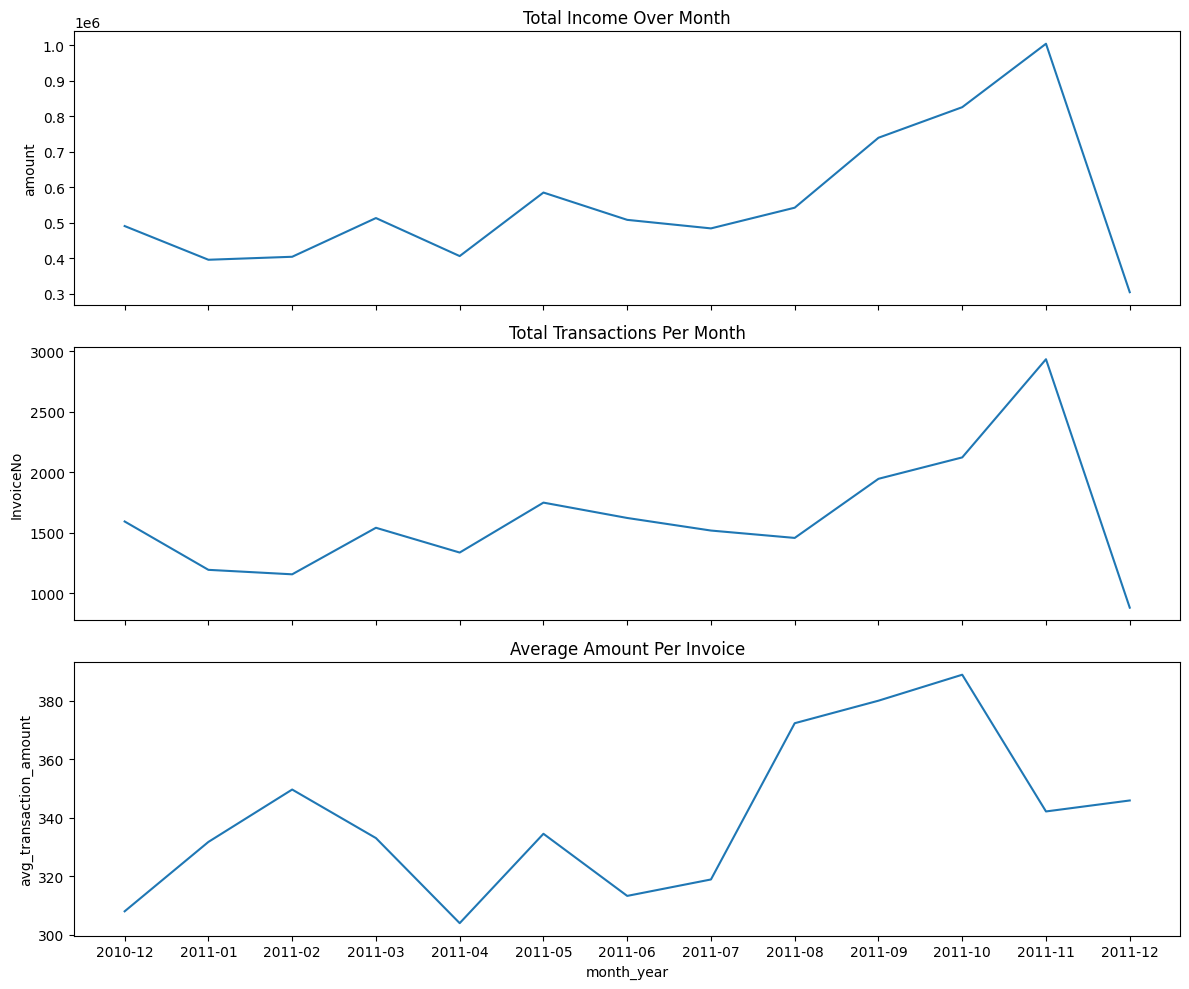

In [11]:
monthly_amount, monthly_transactions, monthly_avg_transaction_amount = monthly_revenue_and_transactions(processed_df)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 10))
sns.lineplot(monthly_amount, x="month_year", y='amount', ax=ax1).set_title(
    'total income over month'.title())
sns.lineplot(monthly_transactions, x="month_year", y=invoiceno, ax=ax2).set_title(
    'total transactions per month'.title())
sns.lineplot(monthly_avg_transaction_amount, x="month_year", y='avg_transaction_amount', ax=ax3
             ).set_title('average amount per invoice'.title())
plt.tight_layout()
plt.show()

from the above plots we can notice that:
- We see a peak in November for income and for transactions amount.
- In terms average amount per invoice, we see a high increase from August with steep decline in November. This explains that the peak in November is due to more transactions and not from more expensive transactions
-    There is a positive trend for total income and total transactions count. This means that the high increase in transactions is part of the cause for the high increase in income.
- Please note that the low numbers in 2011-12 is because we have data untill 09-12-2011

In the next plot i'll add the coutry dimension:

In [12]:
# explore top countries by amount

country_df = country_amount(processed_df, N=processed_df[country].nunique())
country_df[:10]


,Country,amount,amount_percent
0,United Kingdom,5971538.114,0.83
1,Netherlands,284661.540,0.04
2,Germany,221705.710,0.03
3,France,190998.290,0.03
4,Australia,137077.270,0.02
5,Switzerland,55739.400,0.01
6,Spain,52048.080,0.01
7,Belgium,40910.960,0.01
8,Norway,35163.460,0.00
9,Japan,33137.420,0.00


we can see from the above table that 5 countries are responsibe for 95% of the income.<br>
More importantly, we can that the UK has the majority of out bussiness, with 83% of out total income.<br>
let's visualize it for better readability.

In [13]:
# top n countries by amount

n = 5
country_df = country_amount(processed_df, N=n)
top_countries = country_df[:n][country]
title = '95% of the income is coming from the following 5 countries  (83% is coming from the UK)'.title()

fig = px.bar(country_df, x=country, y='amount_percent', text='amount_percent', title=title, color = country
             ).update_layout(showlegend=False, yaxis_range=[0,1]) 
fig.show()

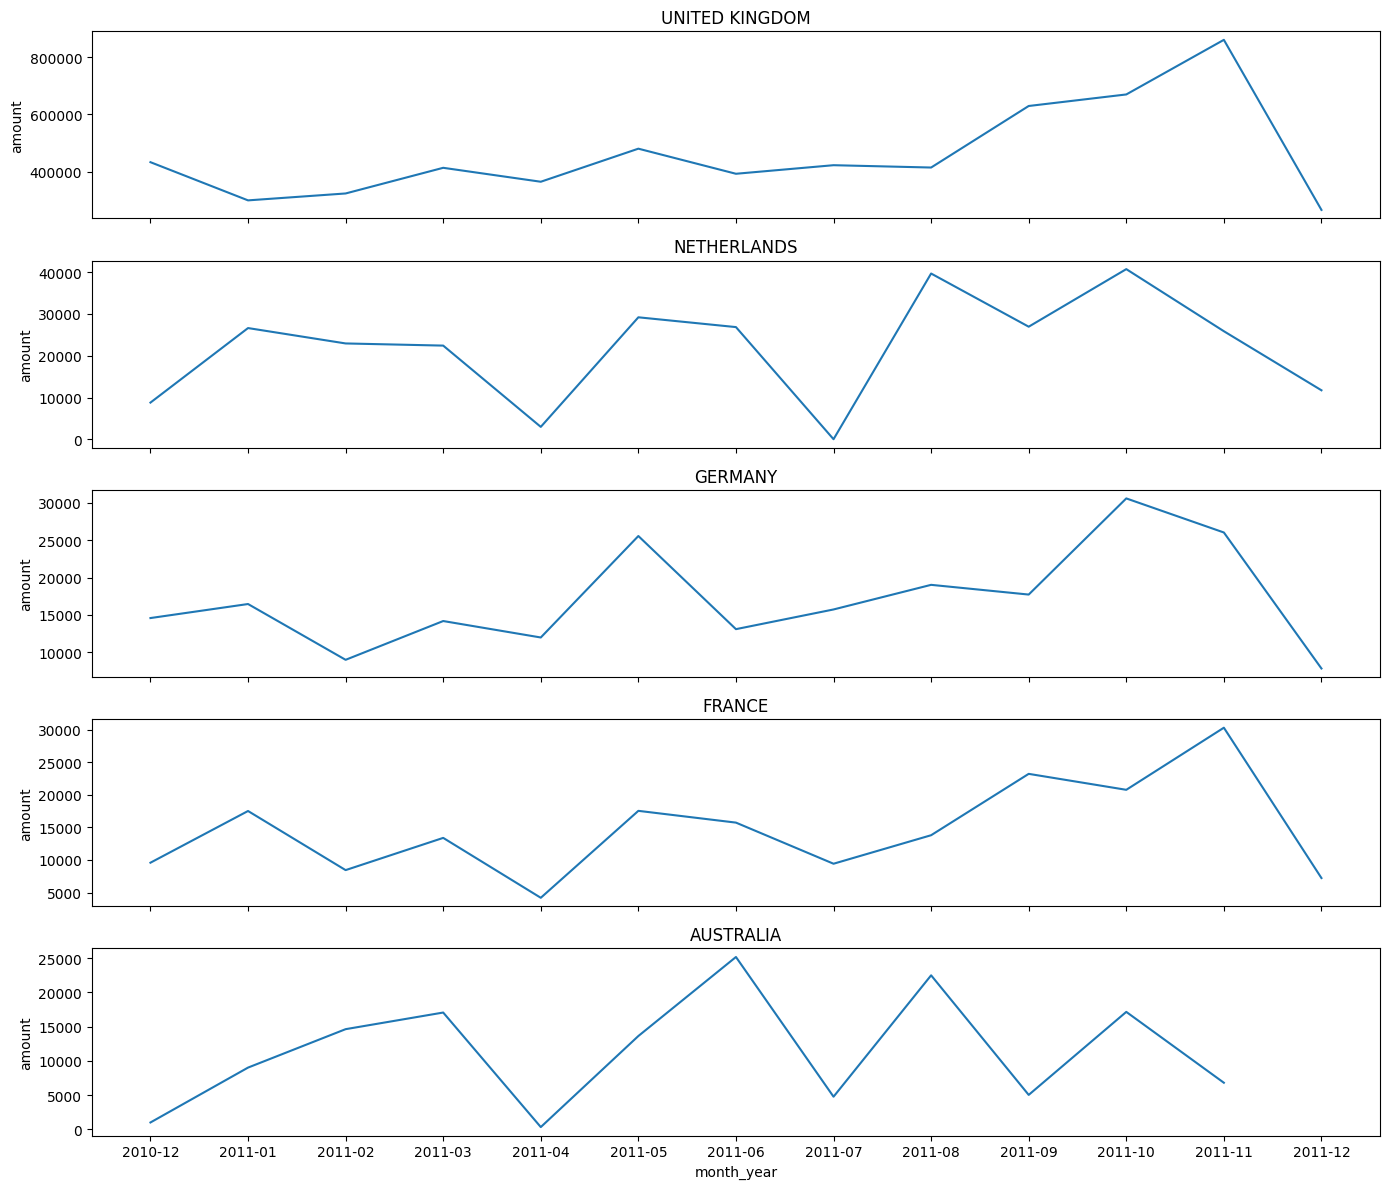

In [14]:
# time series per top countries - amount

country_month_year_top = top_countries_by_month_year(processed_df, top_countries)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(14, 12))
axs = (ax1, ax2, ax3, ax4, ax5)
for i, (ax, country_name) in enumerate(zip(axs, top_countries), start=1):
    country_df_temp = country_month_year_top[country_month_year_top[country] == country_name]
    plt.subplot(n*100 + 10 + i)
    sns.lineplot(country_df_temp, x='month_year', y=amount, ax=ax).set_title(f'{country_name}'.upper())
plt.tight_layout()

from the above plots we can see that like the positive trend for income we saw at the begining, the UK has the same shape.<br>
in the other 4 countries we can see that the time series wiggles.This may be due to the amount of customers or due to external unknown reason (e.g. marketing campaigns).
We also see for the first time a possible indication for dead customers, as in Australia there are no income (take it with a grain of salt - not enogh data in December)

In addition to income, next i'll plot the number of transactions as time series per country

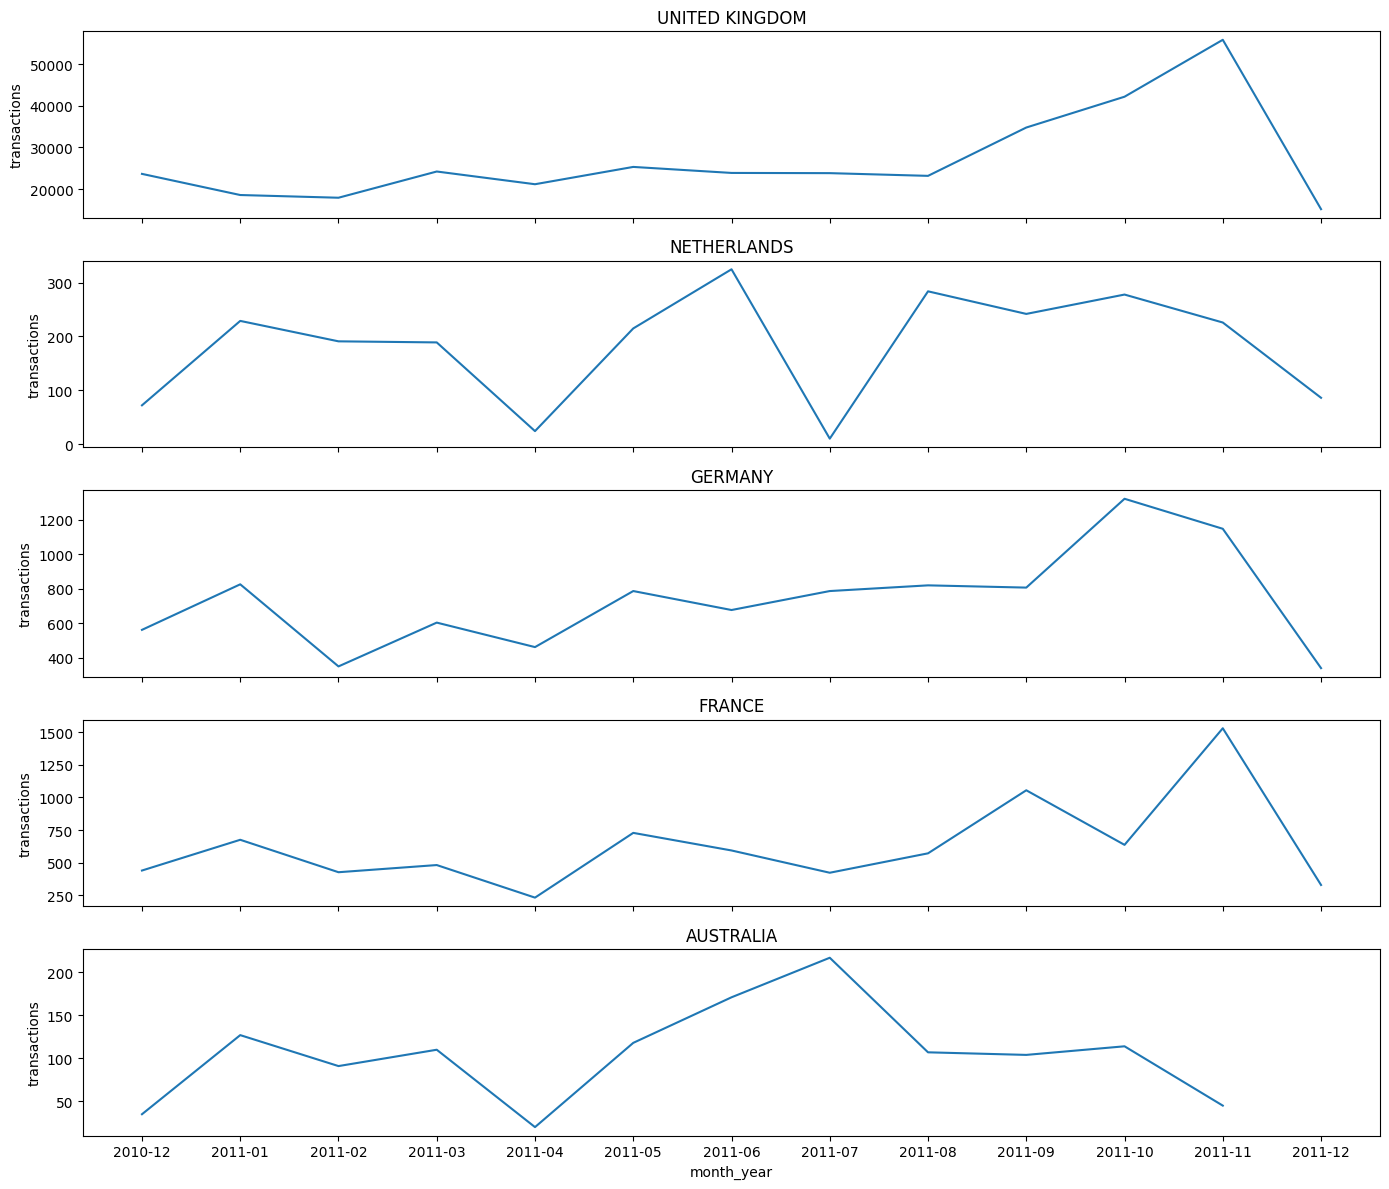

In [15]:
# total transactions per country - time series


month_year_country_rans = processed_df.groupby(['month_year', country], as_index=False)[invoiceno].size().rename(
    columns={'size': 'transactions'})
month_year_country_rans[month_year] = month_year_country_rans[month_year].astype(str)
month_year_country_rans = month_year_country_rans[month_year_country_rans[country].isin(top_countries)]

fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(n, 1, sharex=True, figsize=(14, 12))
axs = [ax1, ax2, ax3,ax4,ax5]
for i, (ax, country_name) in enumerate(zip(axs, top_countries), start=1):
    month_year_country_rans_temp = month_year_country_rans[month_year_country_rans[country] == country_name]
    plt.subplot(n*100 + 10 + i)
    sns.lineplot(month_year_country_rans_temp, x='month_year', y='transactions', ax=ax
                 ).set_title(f'{country_name}'.upper())
plt.tight_layout()

While the other countries have wigles, we see a positive trend in the UK which is directly correlated with the increase in income in those months.

Next, i'll plot the amount of new customers as a time series.


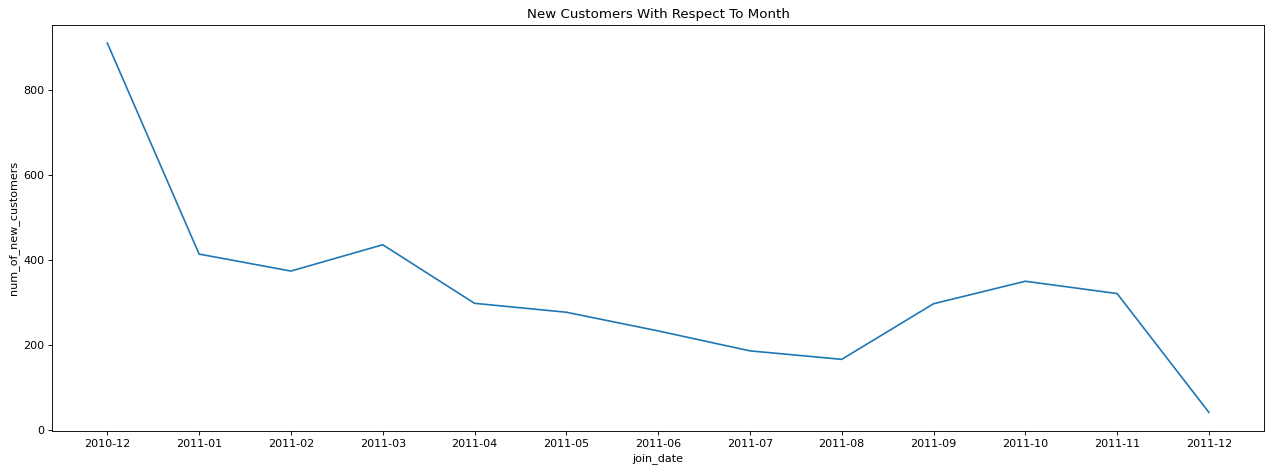

In [16]:
# new customers per month

processed_df['join_date'] = processed_df.groupby(customerid)[invoicedate].transform('min').dt.to_period(freq='M')

join_df = processed_df[['join_date', customerid]].drop_duplicates()
join_df = join_df.groupby(['join_date'], as_index=False)[customerid].nunique().rename(
    columns={customerid: 'num_of_new_customers'})
join_df['join_date'] = join_df['join_date'].astype(str)

figure(figsize=(16, 6), dpi=80)
title = f'new customers with respect to month'.title()
sns.lineplot(join_df, x='join_date', y='num_of_new_customers').set_title(title)
plt.tight_layout()

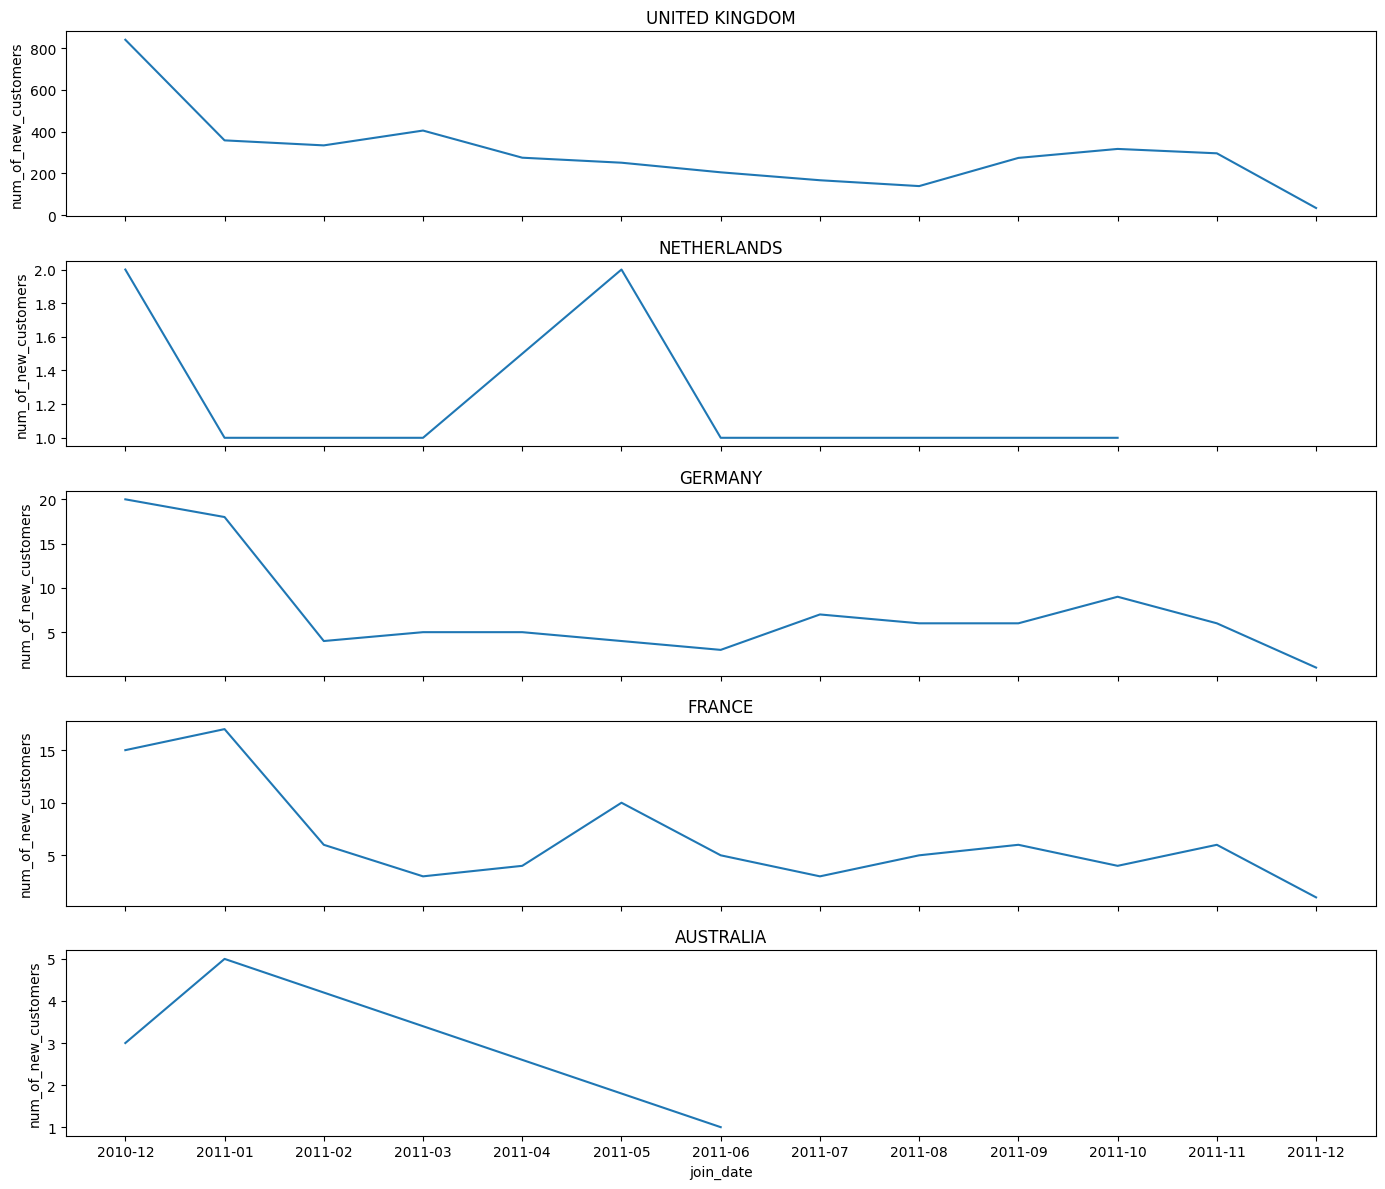

In [17]:
# new customers per month by country

processed_df['join_date'] = processed_df.groupby(customerid)[invoicedate].transform('min').dt.to_period(freq='M')

join_df = processed_df[['join_date', customerid, country]].drop_duplicates()
join_df = join_df.groupby(['join_date', country], as_index=False)[customerid].nunique().rename(
    columns={customerid: 'num_of_new_customers'})
join_df['join_date'] = join_df['join_date'].astype(str)
join_df = join_df[join_df[country].isin(top_countries)]

fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(n, 1, sharex=True, figsize=(14, 12))
axs = (ax1, ax2, ax3,ax4,ax5)
for i, (ax, country_name) in enumerate(zip(axs, top_countries), start=1):
    temp_jon_df = join_df[join_df[country] == country_name]
    plt.subplot(n*100 + 10 + i)
    sns.lineplot(temp_jon_df, x='join_date', y='num_of_new_customers', ax=ax).set_title(f'{country_name}'.upper())
plt.tight_layout()

we can see that as time goes by there are less new customers.<br>
Ideally, the retailer would like to see an increase in each month.<br>
However, since we know that there is an increase in the income in the final quarter, the right customers are staying with them.<br>
Also, we see very little to none new customers in the top countries, excluding the UK. This is a flag and may be a sign for "dying" countries.

Finally, i would like to see two distinct groups - whales and dead customers.<br>
As we saw before, in terms of income, the pareto rule has a place here.<br>
This means that we can segment one group of customers which is responsible for most of the income - the company should do everything it can to keep those customers alive. I call them whales.<br>
The opposite team are the dead customers. while this definition requires more product understanding, a fair assumption would be that a dead customer is one who wasn't active for the past X=180 days. In my analysis I also add the condition of one transaction only, however this may not be true in real life. 

In [18]:
# whales

whales = get_whale_customers(processed_df, q=.95)
print(f'there are total {whales.shape[0]} whale customers')
whales_count = get_whales_by_column(whales, groupby_column=country, top_countries_n=5)
fig = px.bar(whales_count, x=country, y='customers', title='Whales per country'.title(), color = country,
             text='customers'). update_layout(showlegend=False)
fig.show()

there are total 216 whale customers


In [19]:
# dead customers

processed_df['max_date'] = processed_df.groupby(customerid)[invoicedate].transform('max')
processed_df['recency'] = (CURRENT_TIME - processed_df['max_date']).dt.days
dead_customer = processed_df.groupby([customerid, 'recency'], as_index=False)[invoiceno].nunique()
th_dead_customer = 180 # 6 months
mask = (dead_customer['recency'] > th_dead_customer) & (dead_customer[invoiceno] == 1)
print(f'there are total of {dead_customer[mask].shape[0]} dead customers')

there are total of 519 dead customers


In [20]:
# recency distribution

recency_df = create_recency_column(processed_df)
fig = px.box(recency_df, x='recency', title='Recency distribution'.title())
fig.show()

from the above plot we can ce that we have ~25% possible of dead customers, since they didn't engage with us for some time.

### EDA Main Insights

- Income is dispered unevenly across customers - 11.6 % accounted for ~60% of the income
- We can segment those customers to whales, which are the most profitable customers
- Another segmentation is dead customers
- UK is responsible for 83% of the income
- There was an increase in income since August with a peak in November 
- Getting new customer is in negative trend, with some countries have none

## Feature Engineering

The feature engineering steps are:
  - group by customer id
  - add the following columns:
    - RFM Values
    - average items count per transaction
    - average quantity count per transaction



In [21]:
fe = FeatureEngineering()
fe_df = fe.feature_engineering_pipeline(processed_df)
print(f'total customers after applying feature engineering - {processed_df[customerid].nunique()}')

total customers after applying feature engineering - 4304


In [22]:
fe_df.head()

,CustomerID,recency,monetary_value,frequency,unique_items_count,quantity_sold_avg
0,17850.0,301,5288.63,35,8.914286,48.371429
1,13047.0,31,3079.10,18,10.888889,75.277778
2,12583.0,2,7187.34,18,13.944444,278.277778
3,13748.0,95,948.25,5,5.600000,87.800000
4,15100.0,329,635.10,6,1.000000,9.666667


In [23]:
# normalizing

mms = MinMaxScaler()
fe_df_customers = fe_df['CustomerID']
fe_df = fe_df.drop([customerid], axis=1)
X = pd.DataFrame(fe_df, columns=[i for i in fe_df.columns])
X = mms.fit_transform(X)

### elbow method

In [24]:
k_means=ClusterModel(X, elbow_max_clusters=10, model=KMeans)
k_means.elbow_method()

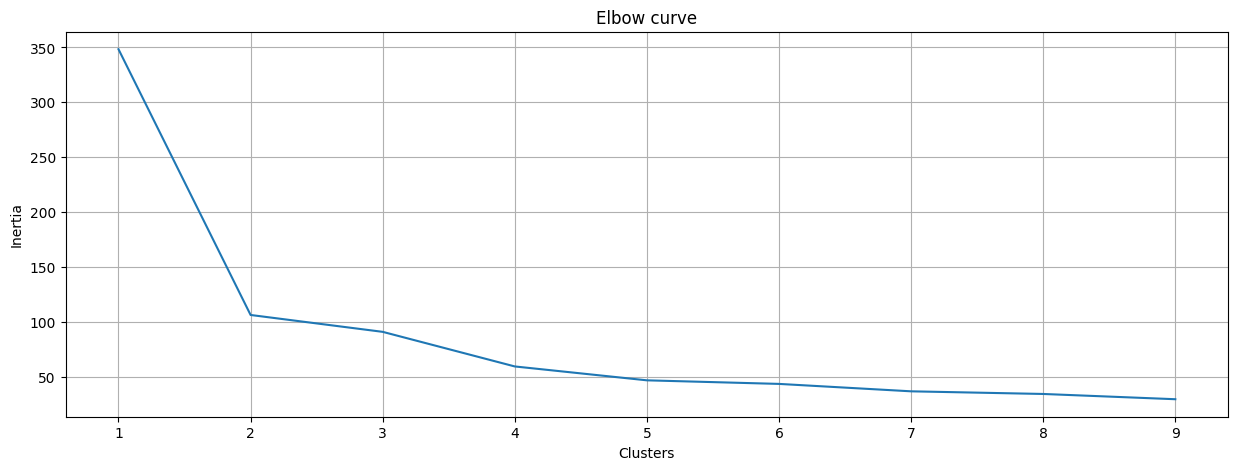

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(k_means.elbow_iter_range, k_means.elbow_distortions)
plt.grid(True)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.show()

from the above elbow plot we see the elbow at 2 clusters. <br>
however, I assume that the retailer would like more granularity, so I'll use 3 clusters.<br>
In real life i would use additional methods for finding the optimal clusters, try and validate various clusters, along with the customer's needs.

## K-means

In [26]:
n_clusters = 3
hyper_params = {'n_clusters': n_clusters, 'random_state': 1}
k_means = ClusterModel(X, elbow_max_clusters=10, model=KMeans, model_hyperparameters=hyper_params)
k_means.fit_model()
fe_df['Cluster'] = k_means.fitted_model.fit_predict(X=k_means.X)
fe_df['Cluster'] += 1

after applying the model, i'll plot the rfm plot for each cluster

In [27]:
fe_df['Cluster'] = fe_df['Cluster'].astype(str)

fig = px.scatter_3d(fe_df, x='recency', y='frequency', z='monetary_value',
                    color='Cluster', title='3D Plot of K-means Clusters on RFM Data'
                    ,width=800, height=800)
fig.show()

let's remove the outliers for better visibility

In [28]:
plot_df = fe_df[fe_df['frequency'] < 50]
plot_df = fe_df[fe_df['monetary_value'] < 100_000]

fig = px.scatter_3d(plot_df, x='recency', y='frequency', z='monetary_value',
                    color='Cluster', title='3D Plot of K-means Clusters on RFM Data'
                    ,width=800, height=800)
fig.show()

we can see that the first cluster is seperated from the other two, while they seems to be overlapping

PCA

In [29]:
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X)
print(f'explained_variance_ratio - {pca.explained_variance_ratio_}')


explained_variance_ratio - [0.87588248 0.08815718 0.02504424 0.00786051 0.00305559]


based on the explained variance, we can see that even one component will "catch" most of the variability. for better visibility i'll plot the first two.

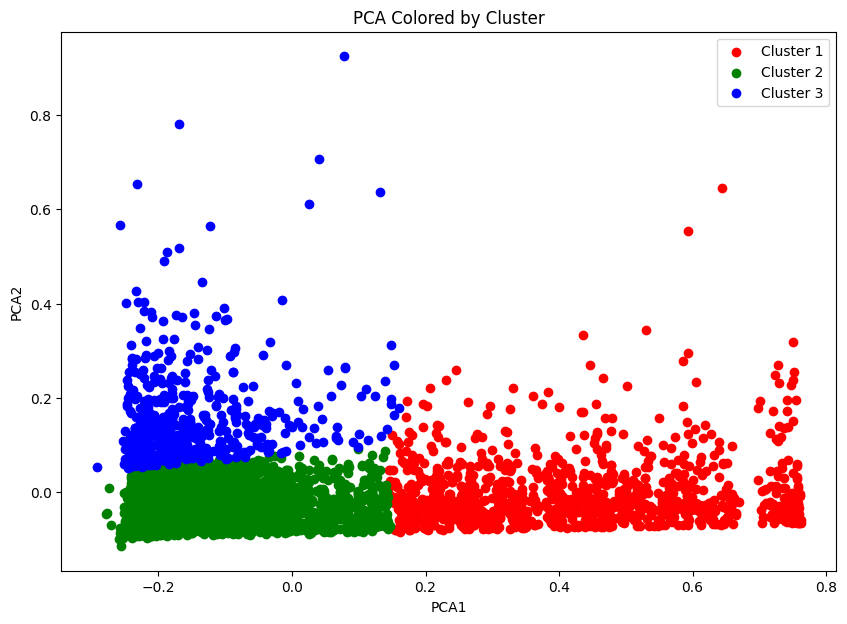

In [30]:

pca_components = PCA(n_components=2)
pca_components = pca.fit_transform(X)

fe_df['PCA1'] = pca_components[:, 0]
fe_df['PCA2'] = pca_components[:, 1]

# Plot the first two PCA components with different colors for each cluster
plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b', 'c', 'm']
for cluster in range(n_clusters):
    clustered_data = fe_df[fe_df['Cluster'] == str(cluster+ 1)]
    plt.scatter(clustered_data['PCA1'],
                clustered_data['PCA2'],
                c=colors[cluster],
                label=f'Cluster {cluster+1}')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Colored by Cluster')
plt.legend()
plt.show()

we can see that the the data is seperated very nicely

### Clusters Evaluation

after getting this clusters, i'll try to profile them for more bussiness recommendations.

In [31]:
# whales per each cluster

fe_df_full = pd.concat([fe_df, fe_df_customers], axis=1)

cluster3 = fe_df_full[fe_df_full['Cluster'] == '3']
cluster2 = fe_df_full[fe_df_full['Cluster'] == '2']
cluster1 = fe_df_full[fe_df_full['Cluster'] == '1']

whales_customer_id_list = whales[customerid]

whales_c3 = cluster3[cluster3[customerid].isin(whales_customer_id_list)].shape[0]
whales_c2 = cluster2[cluster2[customerid].isin(whales_customer_id_list)].shape[0]
whales_c1 = cluster1[cluster1[customerid].isin(whales_customer_id_list)].shape[0]
print(f'Cluster 1 contains {whales_c1} whales')
print(f'Cluster 2 contains {whales_c2} whales')
print(f'Cluster 3 contains {whales_c3} whales')

Cluster 1 contains 4 whales
Cluster 2 contains 184 whales
Cluster 3 contains 28 whales


Ideally, i would like to see the whales in one cluster, with the highest monetary value, while the dead in the lowest.

In [32]:
clusters_per_cluster = fe_df_full.groupby('Cluster', as_index=False)[customerid].size().rename(
    columns={'size': 'num_of_customers'})
clusters_per_cluster

,Cluster,num_of_customers
0,1,1036
1,2,2744
2,3,524


In [33]:
clusters_mv = fe_df_full.groupby('Cluster', as_index=False)['monetary_value'].sum()
clusters_mv

,Cluster,monetary_value
0,1,494136.011
1,2,5648545.163
2,3,1061038.880


In [34]:
clusters_freq = fe_df_full.groupby('Cluster', as_index=False).agg({'frequency': ['mean', 'std']})
clusters_freq

Cluster frequency          
               mean       std
0       1  1.892857  1.868919
1       2  6.106050  8.448470
2       3  4.452290  8.603193

In [35]:
cluster_df = processed_df.merge(fe_df_full[[customerid, 'Cluster']], on=customerid, validate='m:1')
cluster_inc_date = cluster_df.groupby([month_year, 'Cluster'], as_index=False)[amount].sum()
cluster_inc_date[month_year] = cluster_inc_date[month_year].astype(str)
title='total income with respect to month by cluster'.title()
fig = px.line(cluster_inc_date, x=month_year, y='amount', color='Cluster', title=title)
fig.show()

we know that cluster 2 has the largest population, so let's check the average:

In [36]:
title='average income per customer with respect to month'.title()
a = cluster_df.groupby([month_year, 'Cluster'], as_index=False)[amount].mean()
a[month_year] = a[month_year].astype(str)
fig = px.line(a, x=month_year, y='amount', color='Cluster', title=title)
fig.show()

from the above two plots we can see that cluster 1 contains dead customers, so it may be dropped in further clustering processes.<br>
Cluster 2 has the most whales and has the highest amount, both in total and average.<br>
And cluster 3 are potential customers - they give lower income but also have high frequency, which suggests that more targeted marketing has a potential to increase income

## Reporting

As can be seen, we have three distinct customers:<br>

  - The first contains potentially dead customers. They haven't been active July. We need to investigate why (was there a change in products' availability/mixture, prices change etc.)
  - Recommendations:
    - think with product or any other bussiness unit on how to revive them
    - suggest discount on relevant products
    - connect to them via email or social mdeia<br><br>

  - The second cluster are the most profitable customers, which also contains whales.This cluster is responsible for most of the income and the positive trend. Their engagement is relatively small so we need to understand why and if it's a problem or just the nature of wholesale.
  - Recommendations:
    - stay in touch and make sure they're not leaving
    - campaigns to buy more products (not discounts, but incourage to buy more in better price)
    - targeted campaigns for upsale/cross sale
    - add the ability for suggestion new products (such as "people also buy" as in amazon)<br><br>

  - The third cluster are the medium customers. their income is much lower than the whales but their engagement is higher, which may be good indication for targeted marketing.
  - Recommendations:
    - since they are engaging customers, targeted campaigns for upsale/cross sale
    - suggest new products with special price/other benefit



### KPI's

- Total Income - along with revenue
- Number of whales - each whale has the potential to increase the income exponentially
- Number of new customers - more customers means more exposure and potential for more engagemnt
- churn - first, we need to define churn based on the data, i.e. customers who didnt purchase for X days didn't come back for another buy. the KPI will be the number/ratio of churns
- Transaction amount - if we can increase the transaction amount via targeted campaigns, it may indicate for good segmentation and good marketing

 

### Further Analysis:<br>

There are many things that we can do with this dataset:<br>
-    Further analyze cluster 2 - it contains many customers which i believe can be further segmented
-    Define whales as one group, remove dead customers and perform k-means on the remaining data
-    Add country as a feature, may seperate the data better. try out different categorical encoding methods
-    Extract relevant information from the description column. for instance, categorize the item to types
-    Association rules - find patterns for each transaction (frequent itemset)
- We saw that there are suspected customers with high returns - are they indeed fraud? we should advice with the stakeholders
- Analyze the data as time series and LTV, e.g. with BG-NBD modeling


In [37]:
print('The End')

The End
